In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit


In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [4]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])
subject_df = subject_df.drop(["Unnamed: 0.1"], axis=1)

In [5]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [6]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [7]:
statsv_dic = {
    'Run Time': [],
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []
    
}

In [8]:
indaccs_dic = {}

#Support Vector Classifier Linear
#C=0.1 - 94,  #C=1 - 95
SVC_results = []
X= subject_df.iloc[:, 2:17]
Y= subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for v in range(-3, 2):
    model=SVC(C=10**v, kernel='linear')
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('C Value: {}'.format(10**v))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    SVC_results.append(scores.mean())
print(SVC_results)


#Support Vector Classifier Linear
#C=0.5 - 95.3
SVC_results = []
X= subject_df.iloc[:, 2:17]
Y= subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for v in range(0, 2):
    model=SVC(C=5/(10**v), kernel='linear')
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('C Value: {}'.format(10**v))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    SVC_results.append(scores.mean())
print(SVC_results)

In [9]:
#Support Vector Classifier Linear

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = SVC(C=1, kernel='linear', random_state=3)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 2:17]
    X_test = subject_df.iloc[test_index, 2:17]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statsv_dic['Run Time'].append(elapsed)
statsv_dic['Accuracy'].append(np.mean(acc_score))
statsv_dic['Standard Error'].append(np.std(acc_score))
statsv_dic['Sensitivity'].append(sensitivity)
statsv_dic['Specificity'].append(specificity)
statsv_dic['Precision'].append(precision)
statsv_dic['F1_Score'].append(f1_score)

indaccs_dic['SVCLinear'] = acc_score

---Run time is 9290.725041879 seconds ---

Accuracy of each fold: 
 [0.9519334463102758, 0.9514637904468413, 0.9562403697996918, 0.9573189522342065, 0.9559322033898305]
Avg accuracy: 0.9545777524361693
Std of accuracy : 
0.002400088513973496

[[18646   780]
 [  694 12331]]

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     19426
           1       0.94      0.95      0.94     13025

    accuracy                           0.95     32451
   macro avg       0.95      0.95      0.95     32451
weighted avg       0.95      0.95      0.95     32451

0.9598476268917945
0.9467178502879079
0.9641158221302999
0.9619769901460044


#Support Vector Machine Radial
#C=1 - 74,  C=10 - 75,  C=0.1 - 59
SVC_results = []
X= subject_df.iloc[:, 2:17]
Y= subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for v in range(-3, 2):
    model=SVC(C=10**v, gamma=1, kernel='rbf')
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('Cost of Violation: {}'.format(10**v))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    SVC_results.append(scores.mean())
print(SVC_results)

#Support Vector Machine Radial
#C=5.0 - 0.758      C=0.5 - 0.706
SVC_results = []
X= subject_df.iloc[:, 2:17]
Y= subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for v in range(0, 2):
    model=SVC(C=5/(10**v), gamma=1, kernel='rbf')
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('Cost of Violation: {}'.format(5/(10**v)))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    SVC_results.append(scores.mean())
print(SVC_results)

#Support Vector Machine Radial
#G=0.05 - 0.895      #G=0.005 = 0.947
SVC_results = []
X= subject_df.iloc[:, 2:17]
Y= subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for g in range(0, 2):
    model=SVC(C=1, gamma=0.05/(10**g), kernel='rbf')
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('Gamma Value: {}'.format(0.05/(10**g),))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    SVC_results.append(scores.mean())
print(SVC_results)

#Support Vector Machine Radial
#G=0.001- 95,  #G=0.01 - 93, #G=0.1  - 86, #G=0.0001 - 0.95   
SVC_results = []
X= subject_df.iloc[:, 2:17]
Y= subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for g in range(-4, 2):
    model=SVC(C=1, gamma=10**g, kernel='rbf')
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('Gamma Value: {}'.format(10**g))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    SVC_results.append(scores.mean())
print(SVC_results)

In [10]:
#Support Vector Classifier Radial

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = SVC(C=5, gamma=0.001 , kernel='rbf')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 2:17]
    X_test = subject_df.iloc[test_index, 2:17]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statsv_dic['Run Time'].append(elapsed)
statsv_dic['Accuracy'].append(np.mean(acc_score))
statsv_dic['Standard Error'].append(np.std(acc_score))
statsv_dic['Sensitivity'].append(sensitivity)
statsv_dic['Specificity'].append(specificity)
statsv_dic['Precision'].append(precision)
statsv_dic['F1_Score'].append(f1_score)

indaccs_dic['SVCRadial'] = acc_score

---Run time is 101.34511014800046 seconds ---

Accuracy of each fold: 
 [0.9523956247111385, 0.9519260400616333, 0.9525423728813559, 0.9548536209553159, 0.9562403697996918]
Avg accuracy: 0.9535916056818271
Std of accuracy : 
0.0016681728141659878

[[18378  1048]
 [  458 12567]]

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     19426
           1       0.92      0.96      0.94     13025

    accuracy                           0.95     32451
   macro avg       0.95      0.96      0.95     32451
weighted avg       0.95      0.95      0.95     32451

0.9460516833110265
0.9648368522072936
0.9756848587810576
0.9606397992786576


In [11]:
SVCdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statsv_dic["Accuracy"],
                                statsv_dic["Standard Error"],
                                statsv_dic["Sensitivity"],
                                statsv_dic["Specificity"],
                                statsv_dic["Precision"],
                                statsv_dic["F1_Score"],
                                statsv_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

SVCdf.set_index(pd.Index(["SVC Linear", "SVC Radial"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
SVC Linear,0.954578,0.002400,0.959848,0.946718,0.964116,0.961977,9290.725042
SVC Radial,0.953592,0.001668,0.946052,0.964837,0.975685,0.960640,101.345110


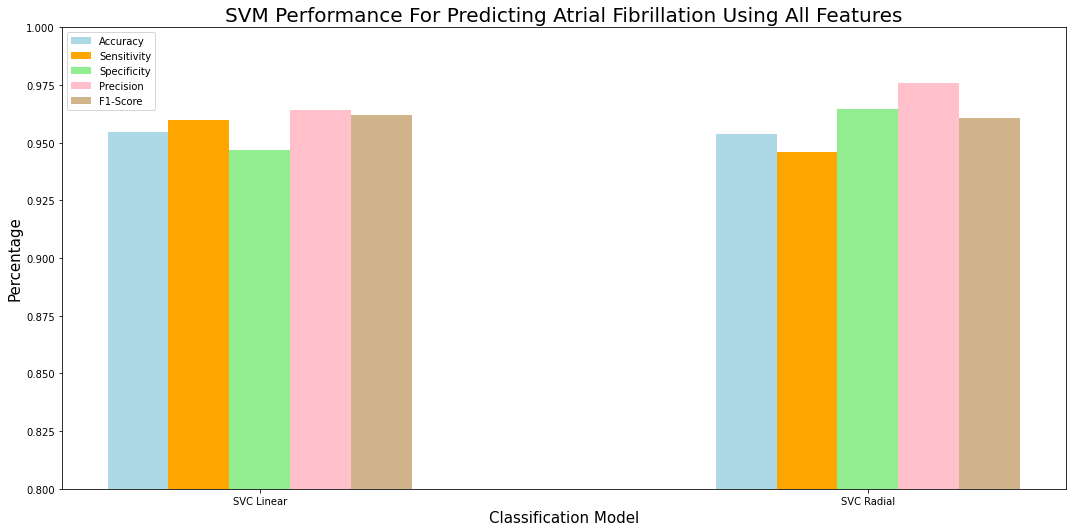

In [12]:
models = ['SVC Linear', 'SVC Radial']
accuracies = statsv_dic["Accuracy"]
sensitivities = statsv_dic["Sensitivity"]
specificities = statsv_dic["Specificity"]
precisions = statsv_dic["Precision"]
f1_scores = statsv_dic["F1_Score"]



x = 6*np.arange(len(models))
width = 0.6

fig, ax = plt.subplots(figsize=(15, 7.5))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color="lightblue")
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color="orange")
spe = ax.bar(x,specificities, width, label='Specificity', color="lightgreen")
pre = ax.bar(x+width, precisions, width, label='Precision', color="pink")
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1-Score', color="tan")

ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Percentage', fontsize=15)
ax.set_title('SVM Performance For Predicting Atrial Fibrillation Using All Features', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set(ylim=(0.80, 1.0))
ax.legend()

#ax.bar_label(acc, padding=3)
#ax.bar_label(sen, padding=3)
#ax.bar_label(spe, padding=3)
#ax.bar_label(pre, padding=3)
#ax.bar_label(f1, padding=3)


fig.tight_layout()

plt.legend(loc="upper left")
plt.show()

fig.savefig('SVMResults.png')
#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

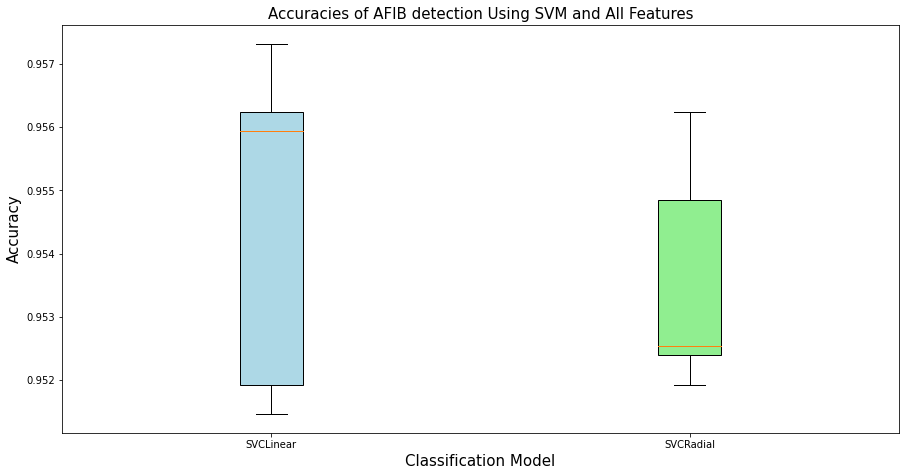

In [13]:
#Box Plot Accuracies

models = ['SVCLinear', 'SVCRadial']

x = np.arange(len(models))+1

SVCLinear = indaccs_dic['SVCLinear']
SVCRadial = indaccs_dic['SVCRadial']

data = [SVCLinear, SVCRadial]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)


ax.set_title('Accuracies of AFIB detection Using SVM and All Features', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

colors = ['lightblue', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

fig.savefig('SVMAccuraciesBoxPlots.png')